In [54]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [55]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


# Training a neural network with PyTorch

This notebook trains a neural network to approximate the $\sin$ function, but using `PyTorch` instead of `NumPy`.

First thing to note: `PyTorch` can almost be used as a `NumPy` replacement, with tensors instead of arrays. Because `PyTorch` allows computations on GPU, we can choose on which device to store the tensors.

In [56]:
n = 1024
x = np.random.uniform(-np.pi, np.pi, size=(n, 1)).astype(np.float32)
y = np.sin(x).astype(np.float32)

# Normalize inputs (helps training)
x_mean, x_std = x.mean(), x.std()
x_n = (x - x_mean) / x_std

# Convert to torch tensors
x_t = torch.from_numpy(x_n).to(device)   # normalized x
y_t = torch.from_numpy(y).to(device)     # target y

To create a neural network, we create a class that inherits the properties of the `nn.Module` class. 

This class defines the number of hidden layers, and the forward method.

In [57]:
Nh = 32

class SimpleNetwork(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim), # one input 
            nn.Tanh(),
            #nn.Linear(hidden_dim, hidden_dim), # one output
            #nn.ReLU(),
            nn.Linear(hidden_dim, 1), # one output
            nn.Tanh()                # output constraint: (-1, 1)

        )
        
    def forward(self, x):
        yhat = self.net(x)
        return yhat
    
model = SimpleNetwork(Nh).to(device)

We can then choose a loss function, and a built-in optimizer. 

An often-used optimize is ADAM, which is an improved version of SGD with additional tricks.

In [58]:
criterion = nn.MSELoss() # MSE loss = mean((yhat - y)^2)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr) # SGD version

We have built our network and chosen an optimizer, and that is all we need to do! 

For the backward step, PyTorch automatically builds a "computation-graph" when doing the forward pass, and uses it to compute the gradient with automatic differentiation.

Automatic differentiation is fast, and precise up to machine level precision!

It also means that we get the derivatives "for free" when we evaluate the network.

In [59]:
batch = 256
steps = 150_000  # PyTorch converges fast here; increase if you want

for t in range(steps):
    # Draw a new batch
    idx = torch.randint(low=0, high=n, size=(batch,), device=device) 
    xb = x_t[idx]   # (B, 1)
    yb = y_t[idx]   # (B, 1)

    # Forward pass: compute prediction
    yhat = model(xb)

    # Compute loss
    loss = criterion(yhat, yb)

    # Backward pass: compute gradients dL/dtheta automatically
    optimizer.zero_grad()   # IMPORTANT: clear old gradients
    loss.backward()         # fills .grad for each parameter
    optimizer.step()        # updates parameters using those gradients

    if (t + 1) % 500 == 0:
        print(f"step {t+1:5d} | loss {loss.item():.6f}")



step   500 | loss 0.262746
step  1000 | loss 0.174010
step  1500 | loss 0.123176
step  2000 | loss 0.112576
step  2500 | loss 0.120242
step  3000 | loss 0.099487
step  3500 | loss 0.104248
step  4000 | loss 0.108942
step  4500 | loss 0.109322
step  5000 | loss 0.089783
step  5500 | loss 0.110361
step  6000 | loss 0.086744
step  6500 | loss 0.085678
step  7000 | loss 0.068700
step  7500 | loss 0.056988
step  8000 | loss 0.037607
step  8500 | loss 0.029010
step  9000 | loss 0.019567
step  9500 | loss 0.016677
step 10000 | loss 0.014895
step 10500 | loss 0.013688
step 11000 | loss 0.012264
step 11500 | loss 0.013075
step 12000 | loss 0.012364
step 12500 | loss 0.011316
step 13000 | loss 0.010921
step 13500 | loss 0.010085
step 14000 | loss 0.009622
step 14500 | loss 0.009074
step 15000 | loss 0.007676
step 15500 | loss 0.008530
step 16000 | loss 0.008486
step 16500 | loss 0.008326
step 17000 | loss 0.007528
step 17500 | loss 0.007907
step 18000 | loss 0.007986
step 18500 | loss 0.006966
s

test MSE: 9.6579344e-05


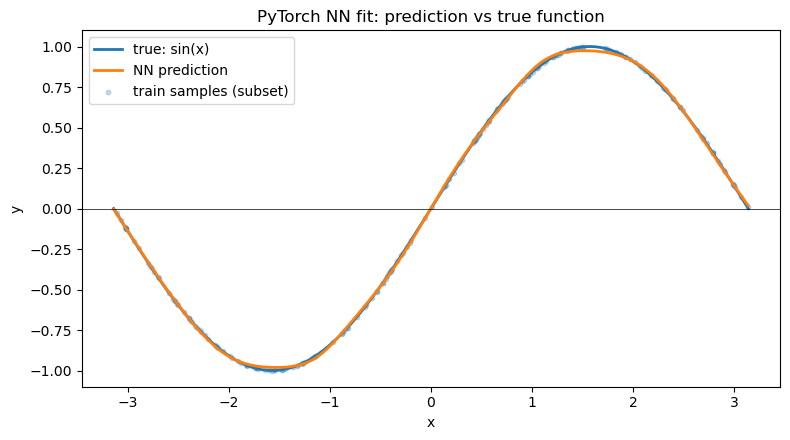

In [60]:
# ----------------------------
# 5) Evaluation + plot
# ----------------------------
# Test grid (in original x units)
x_grid = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1).astype(np.float32)
y_true = np.sin(x_grid).astype(np.float32)
x_grid_n = (x_grid - x_mean) / x_std

xg = torch.from_numpy(x_grid_n).to(device)

model.eval()
with torch.no_grad():
    y_pred = model(xg).cpu().numpy()

mse = np.mean((y_pred - y_true) ** 2)
print("test MSE:", mse)

plt.figure(figsize=(8, 4.5))
plt.plot(x_grid, y_true, label="true: sin(x)", linewidth=2)
plt.plot(x_grid, y_pred, label="NN prediction", linewidth=2)
plt.scatter(x[:200], y[:200], s=10, alpha=0.25, label="train samples (subset)")
plt.axhline(0, color="black", linewidth=0.5)
plt.title("PyTorch NN fit: prediction vs true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 6) (Pedagogical) What PyTorch is doing for you
# ----------------------------
# - model.parameters() contains W1, b1, W2, b2
# - loss.backward() applies the chain rule to compute all gradients:
#     dL/dW1, dL/db1, dL/dW2, dL/db2
# - optimizer.step() performs the SGD update using these gradients
